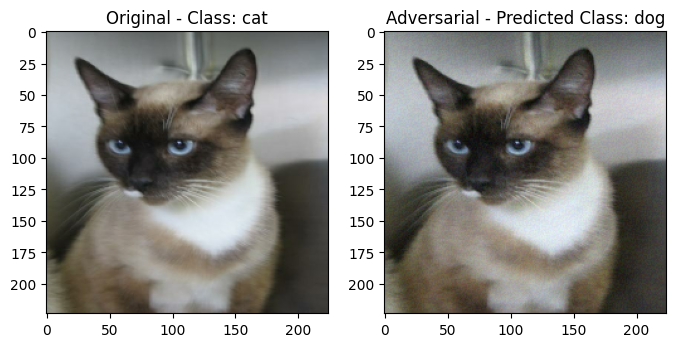

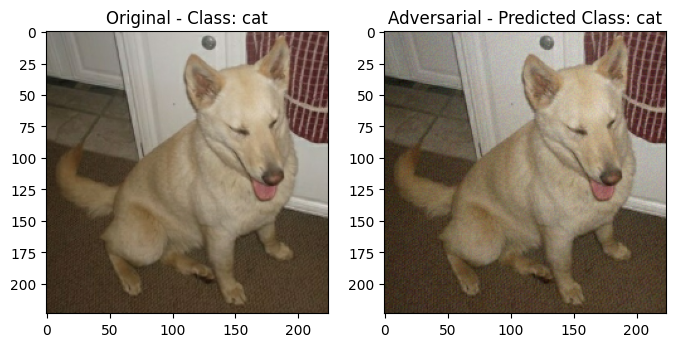

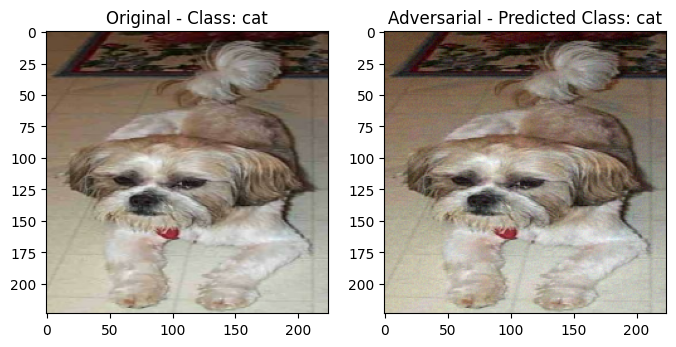

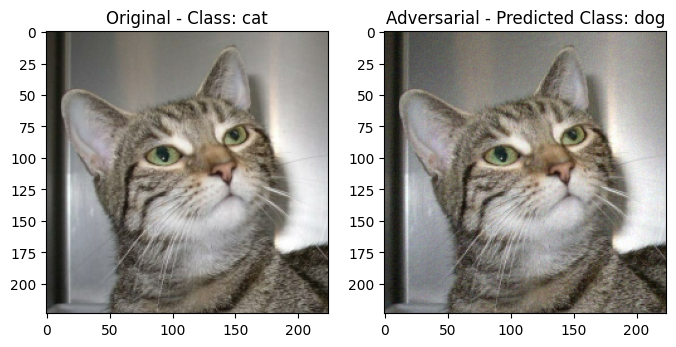

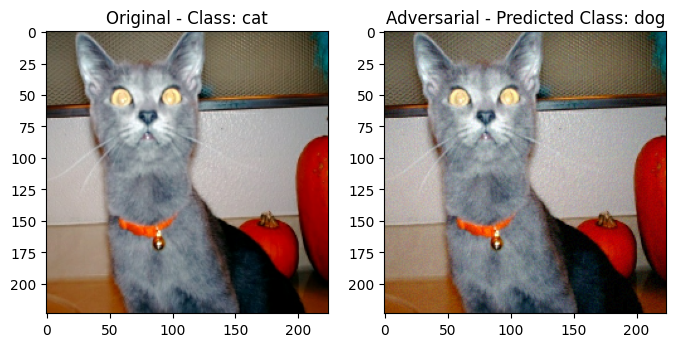

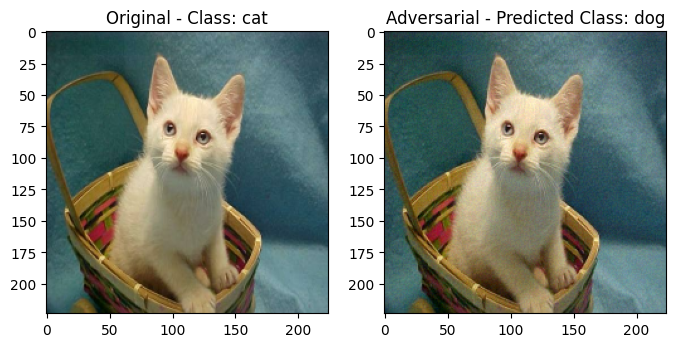

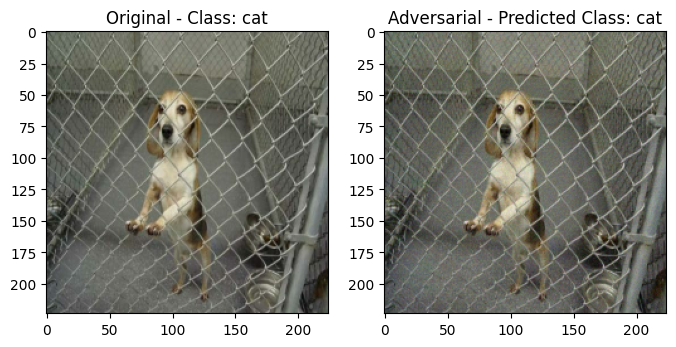

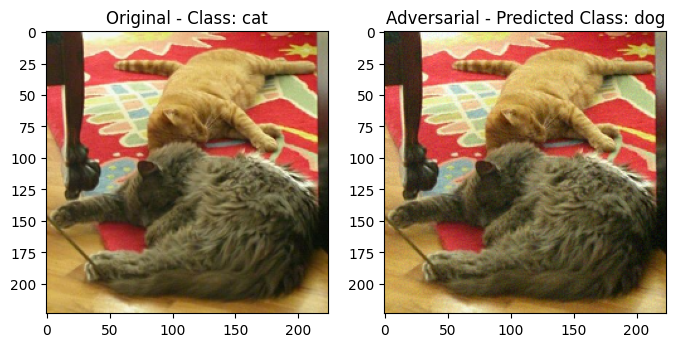

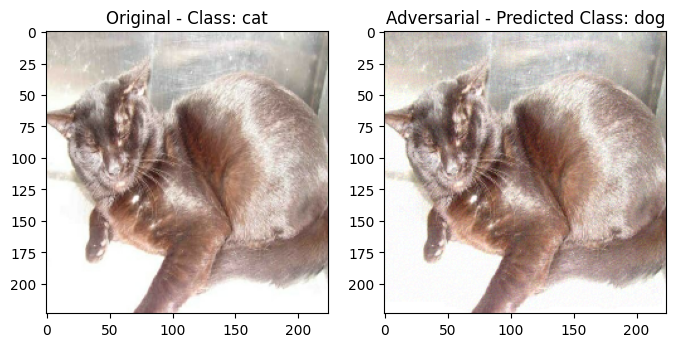

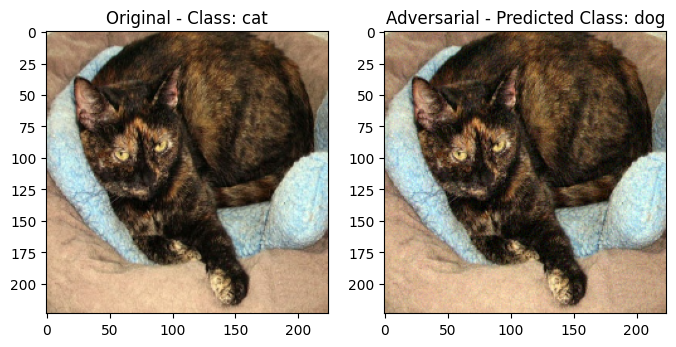

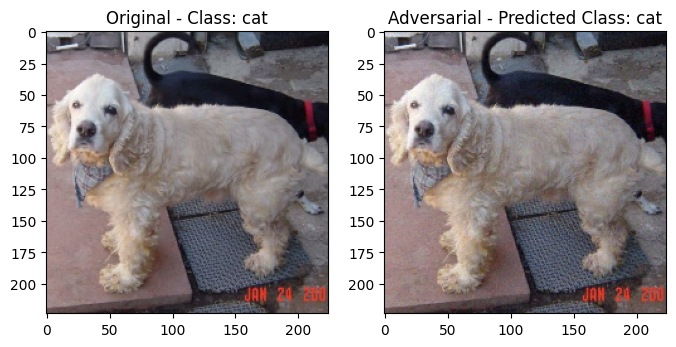

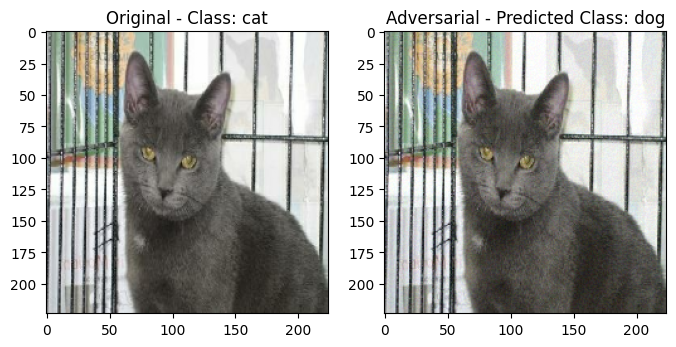

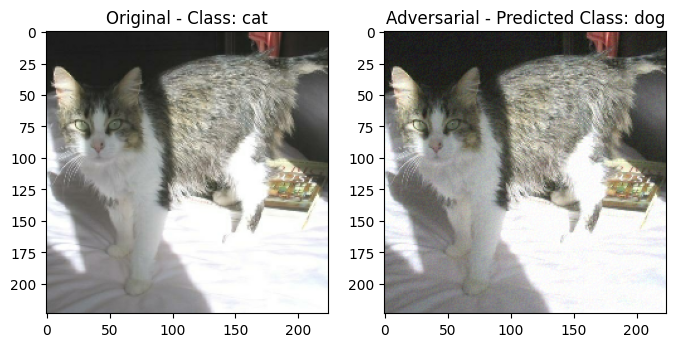

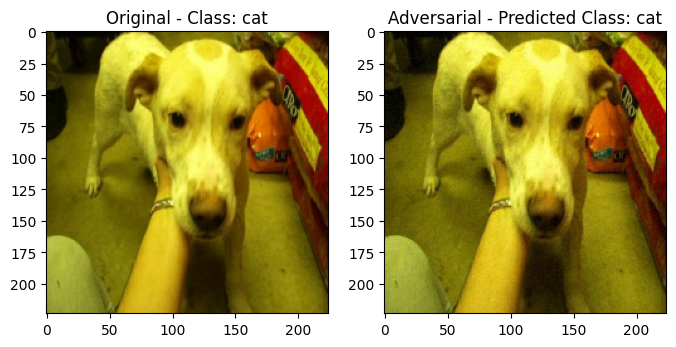

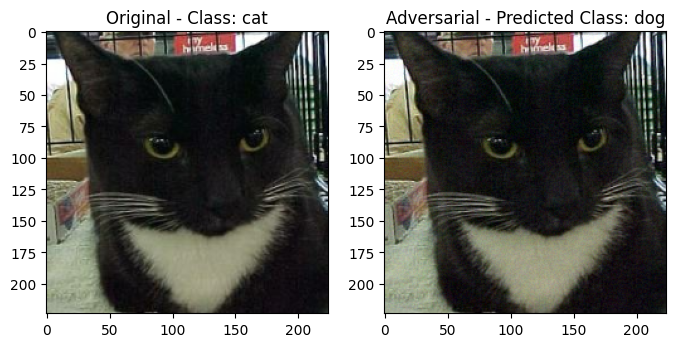

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
dataset, dataset_info = tfds.load('cats_vs_dogs', split='train', with_info=True, as_supervised=True)
num_classes = 2
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label, num_classes)
    return image, label
dataset = dataset.map(preprocess_image)
num_samples = dataset_info.splits['train'].num_examples
num_train_samples = int(0.8 * num_samples)
num_val_samples = int(0.1 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples
train_dataset = dataset.take(num_train_samples)
remaining_dataset = dataset.skip(num_train_samples)
val_dataset = remaining_dataset.take(num_val_samples)
test_dataset = remaining_dataset.skip(num_val_samples)
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
class_names = dataset_info.features['label'].names
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# GAN
def build_generator(latent_dim):
    model = Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(3, activation='tanh'))
    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator((224, 224, 3))

test_batch = next(iter(test_ds))
test_images, test_labels = test_batch
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
attack = FastGradientMethod(estimator=art_classifier, eps=0.02)
adversarial_test_images = attack.generate(test_images.numpy(), y=test_labels.numpy())
num_adversarial_images = adversarial_test_images.shape[0]
num_display = min(num_adversarial_images, 15)
for i in range(num_display):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title(f'Original - Class: {class_names[np.argmax(test_labels[i].numpy())]}')  # Use np.argmax to get the index
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_test_images[i])
    plt.title(f'Adversarial - Predicted Class: {class_names[np.argmax(art_classifier.predict(adversarial_test_images[i][tf.newaxis, ...]))]}')
    plt.show()
    #Here we are looking at the original class and also the predicted class using GAN and ART which allowed to combine them both together, we are able to see that it is sucessfully confusing the AI model.


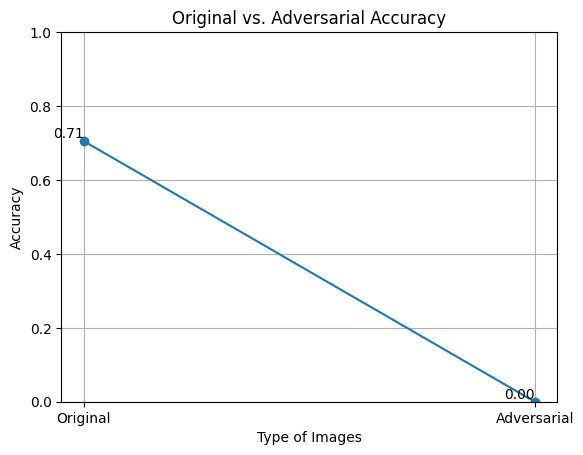

In [10]:
epochs = np.arange(2)
accuracies = np.array([original_accuracy, adversarial_accuracy])
plt.plot(epochs, accuracies, marker='o')
plt.xticks(epochs, ['Original', 'Adversarial'])
plt.xlabel('Type of Images')
plt.ylabel('Accuracy')
plt.title('Original vs. Adversarial Accuracy')
plt.ylim(0, 1)
plt.grid(True)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='right', va='bottom')

plt.show()


In [47]:
adversarial_test_loss, adversarial_test_acc = model.evaluate(adversarial_test_images)
print(f'Adversarial Test Accuracy: {adversarial_test_acc}')
original_test_predictions = model.predict(test_images.numpy())
original_test_labels = np.argmax(original_test_predictions, axis=1)
print('Original Test Labels:', original_test_labels)
adversarial_test_predictions = model.predict(adversarial_test_images)
adversarial_test_labels = np.argmax(adversarial_test_predictions, axis=1)
print('Adversarial Test Labels:', adversarial_test_labels)


1/1 [==============================] - 0s 51ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Adversarial Test Accuracy: 0.0
1/1 [==============================] - 3s 3s/step
Original Test Labels: [1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1]
1/1 [==============================] - 1s 978ms/step
Adversarial Test Labels: [1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1]
